In [1]:
import os
import glob
import lzma
import pickle
import cv2
import numpy as np
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset
from scripts.models2 import *


In [2]:
# Color followed in the npz file as numpy array
COLOR = [[255, 0, 0], [0, 0, 255], [0, 255, 255]]

In [3]:
#class with image and color to follow
class SnapshotToTrain:
    def __init__(self, image, color_followed, current_controls):
        self.image = image
        self.color_followed = color_followed
        self.current_controls = current_controls

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        return self.image[idx], self.color_followed, self.current_controls
    

In [4]:
# Function to process each pair of snapshots for speed
def process_snapshot_pair(snapshot1, snapshot2):
    if snapshot1.image is not None and snapshot2.image is not None:
        # Resize images to a consistent size
        resized_image1 = cv2.resize(snapshot1.image, IMAGE_SIZE)
        resized_image2 = cv2.resize(snapshot2.image, IMAGE_SIZE)

        #bgr to rgb conversion
        resized_image1 = cv2.cvtColor(resized_image1, cv2.COLOR_BGR2RGB)
        resized_image2 = cv2.cvtColor(resized_image2, cv2.COLOR_BGR2RGB)
        

        # Concatenate images along the color channel
        concatenated_image = np.concatenate((resized_image1, resized_image2), axis=2) # axis=2 for color



        return concatenated_image, snapshot2.current_controls
    else:
        print("Warning: Missing image in one or both snapshots")

In [5]:
# Constants
IMAGE_SIZE = (227,227)  # Resize all images to 128x128

# Data Containers
snapshots = []


# Data Preprocessing
for record in glob.glob("*.npz"):
    try:
        with lzma.open(record, "rb") as file:
            data = pickle.load(file)
            print(f"Read {len(data)} snapshots from {record}")
            
            # Parse npz name to take the number of the file record_0.npz -> 0
            npz_number = int(record.split("_")[1].split(".")[0])

            color_followed=COLOR[npz_number]

            # Process consecutive snapshot pairs
            for i in range(len(data) - 1):  # Ensure we have pairs
                image,controls=process_snapshot_pair(data[i], data[i + 1])
                snapshots.append(SnapshotToTrain(image, color_followed,controls))
                
    except EOFError:
        print("Error: Compressed file ended before the end-of-stream marker was reached.")
    except Exception as e:
        print(f"An error occurred: {e}")

print(f"Total concatenated snapshots read: {len(snapshots)}")


package_folder: /home/francisco/.conda/envs/myenv/lib/python3.12/site-packages/ursina
asset_folder: /home/francisco/.conda/envs/myenv/lib/python3.12/site-packages
Read 1030 snapshots from record_0.npz
Read 1054 snapshots from record_1.npz
Read 1017 snapshots from record_2.npz
Total concatenated snapshots read: 3098


In [6]:
def augment_data(snapshots):
    # Augment Data: Flip images and modify labels
    snapshots_augmented=[]

    for snap in snapshots:
        image=snap.image
        color=snap.color_followed
        ctrl=snap.current_controls
        
        # Ajouter l'image originale et les contrôles
        snapshots_augmented.append(SnapshotToTrain(image, color,ctrl))
        
        # Inverser l'image horizontalement
        flipped_img = image[:, :, ::-1]  # Inverser l'axe x
        
        #  inversion gauche droits
        flipped_ctrl= (ctrl[0],ctrl[1],ctrl[3],ctrl[2])

        # Ajouter l'image inversée et les nouveaux contrôles
        snapshots_augmented.append(SnapshotToTrain(flipped_img, color,flipped_ctrl))
    
    return snapshots_augmented

In [7]:
snapshots_augmented = augment_data(snapshots)

snapshots_augmented[1].color_followed

[255, 0, 0]

In [8]:
from collections import Counter
import numpy as np

# Assuming `data_controls` is a list of one-hot encoded control actions
data_controls = [snap.current_controls for snap in snapshots_augmented]


#count each class
class_counts = Counter(data_controls)
print("Class Counts:", class_counts)




Class Counts: Counter({(1, 0, 0, 0): 2072, (1, 0, 1, 0): 1234, (1, 0, 0, 1): 1234, (0, 0, 0, 1): 476, (0, 0, 1, 0): 476, (0, 1, 0, 1): 265, (0, 1, 1, 0): 265, (0, 0, 0, 0): 100, (0, 1, 0, 0): 58, (1, 0, 1, 1): 14, (0, 0, 1, 1): 2})


In [9]:
from sklearn.model_selection import train_test_split


# Split data into training and test sets
train_snapshots, test_snapshots = train_test_split(snapshots_augmented, test_size=0.2, random_state=42)

#check size 
print(len(train_snapshots))
print(len(test_snapshots))



4956
1240


In [10]:
#check if my data is unbalanced
from collections import Counter
import numpy as np

# Assuming `data_controls` is a list of one-hot encoded control actions
data_controls = [tuple(snap.current_controls) for snap in train_snapshots]
print("Class Counts:", data_controls)

# count each class
class_counts = Counter(data_controls)
print("Class Counts:", class_counts)

#find all the controls where controls [0] is 1, control[1] is 1 and so on count
control_0_counts = sum(1 for control in data_controls if control[0] == 1)
control_1_counts = sum(1 for control in data_controls if control[1] == 1)
control_2_counts = sum(1 for control in data_controls if control[2] == 1)
control_3_counts = sum(1 for control in data_controls if control[3] == 1)
print(f"control 0: {control_0_counts}, control 1: {control_1_counts}, control 2: {control_2_counts}, control 3: {control_3_counts}")

Class Counts: [(0, 0, 1, 0), (0, 1, 0, 0), (0, 0, 0, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 0), (1, 0, 0, 0), (0, 0, 1, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 0, 0), (0, 1, 0, 1), (1, 0, 0, 0), (0, 0, 1, 0), (1, 0, 1, 0), (1, 0, 1, 0), (1, 0, 0, 1), (0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (0, 1, 1, 0), (1, 0, 0, 0), (0, 1, 0, 1), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 1, 0), (0, 1, 1, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 1), (1, 0, 1, 0), (0, 1, 1, 0), (1, 0, 1, 0), (0, 1, 0, 1), (0, 1, 1, 0), (1, 0, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 0), (1, 0, 0, 1), (0, 0, 1, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (0, 0, 1, 0), (0, 0, 0, 1), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 1), (1, 0, 1, 0), (0, 1, 0, 1), (1, 0, 1, 0), (0, 1, 0, 1), (0, 0, 1, 0), (1, 0, 0, 1), (0, 0

In [11]:
# Custom collate function for DataLoader
def my_collate(batch):
    images = np.array([item.image for item in batch])  # Convert to numpy array
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to tensor, HWC -> CHW
    
    colors = np.array([item.color_followed for item in batch])  # Already RGB values
    colors = torch.tensor(colors, dtype=torch.float32)  # Convert to PyTorch tensor
    
    controls = torch.tensor([item.current_controls for item in batch], dtype=torch.float32)
    
    return images, colors, controls


In [12]:
# DataLoader
batch_size = 16
train_loader = DataLoader(train_snapshots, batch_size=batch_size, shuffle=True, collate_fn=my_collate)
test_loader = DataLoader(test_snapshots, batch_size=batch_size, shuffle=False, collate_fn=my_collate)

In [13]:
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleImageColorNet(num_classes=4).to(device)

# class weithtscontrol 0: 3730, control 1: 424, control 2: 1795, control 3: 1845
#class_weights = torch.tensor([1/3730/2, 1/424, 1/1795/2, 1/1845], dtype=torch.float32).to(device)

#multi class cross entropy loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Tracking loss and accuracy
train_loss_history = []
test_loss_history = []


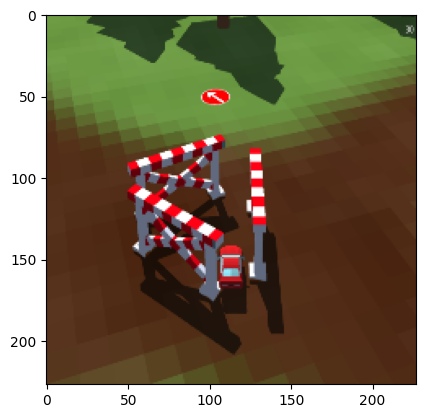

In [14]:
train_snapshots[0].image
#diisplay image
import matplotlib.pyplot as plt
plt.imshow(train_snapshots[0].image[:,:,0:3])
plt.show()


In [15]:
for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for i, (images, colors, controls) in enumerate(train_loader):
        images = images.to(device)
        colors = colors.to(device)
        controls = controls.to(device)
        
        # Forward pass
        outputs = model(images, colors)
        
        # Compute loss
        loss = criterion(outputs, controls)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)

    # Testing loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, colors, controls in test_loader:
            images = images.to(device)
            colors = colors.to(device)
            controls = controls.to(device)
            
            # Forward pass
            outputs = model(images, colors)
            
            # Compute loss
            loss = criterion(outputs, controls)
            test_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += controls.size(0)
            correct += (predicted == torch.argmax(controls, dim=1)).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")


Epoch [1/30], Train Loss: 2.7062, Test Loss: 1.7988, Accuracy: 75.89%
Epoch [2/30], Train Loss: 1.7913, Test Loss: 1.7673, Accuracy: 75.89%
Epoch [3/30], Train Loss: 1.7328, Test Loss: 1.6963, Accuracy: 75.89%
Epoch [4/30], Train Loss: 1.6967, Test Loss: 1.6822, Accuracy: 75.89%
Epoch [5/30], Train Loss: 1.6657, Test Loss: 1.6538, Accuracy: 75.89%
Epoch [6/30], Train Loss: 1.6850, Test Loss: 1.7279, Accuracy: 75.89%


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model.pth")